In [17]:
%matplotlib inline
import os.path
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import erf

import refnx
from refnx.dataset import ReflectDataset, Data1D
from refnx.reflect import SLD, MaterialSLD, ReflectModel, Component
from refnx.analysis import Objective, CurveFitter, Transform, possibly_create_parameter
from refnx.analysis import Parameter, Parameters
from refnx.reflect import SLD, Slab, Structure, ReflectModel

np.random.seed(1)

In [18]:
#data = ReflectDataset("interS/curve5518.txt")
data = ReflectDataset("Pilatus_Interpolated.txt")
print(data)

<Pilatus_Interpolated>, 256 points


In [19]:
class PTCDI(Component):
    def __init__(
        self,
        nlayers,
        monolayer_thickness,
        rel_roughness,
        sld_box1,   # <----- this is closest to the phase layer
        sld_box2,
        thick_frac,
        sig1_rel_pos,  # <------ counting from backing to fronting direction
        sig1_width,
        sig2_rel_pos,  # <------ counting from backing to fronting direction
        sig2_width,
    ):
        super().__init__()
        self.nlayers = possibly_create_parameter(nlayers)
        self.monolayer_thickness = possibly_create_parameter(monolayer_thickness)
        self.rel_roughness = possibly_create_parameter(rel_roughness)
        self.sld_box1 = possibly_create_parameter(sld_box1)
        self.sld_box2 = possibly_create_parameter(sld_box2)
        self.thick_frac = possibly_create_parameter(thick_frac)
        self.sig1_rel_pos = possibly_create_parameter(sig1_rel_pos)
        self.sig1_width = possibly_create_parameter(sig1_width)
        self.sig2_rel_pos = possibly_create_parameter(sig2_rel_pos)
        self.sig2_width = possibly_create_parameter(sig2_width)

    @property
    def parameters(self):
        return Parameters([
            self.nlayers,
            self.monolayer_thickness,
            self.rel_roughness,
            self.sld_box1,
            self.sld_box2,
            self.thick_frac,
            self.sig1_rel_pos,
            self.sig1_width,
            self.sig2_rel_pos,
            self.sig2_width,
        ])
            
    def slabs(self, structure=None):
        nlayers = int(np.round(self.nlayers.value))
        monolayer_thickness = self.monolayer_thickness.value
        rel_roughness = self.rel_roughness.value        
        s_width1 = self.sig1_width.value
        s_width2 = self.sig2_width.value
        s_start1 = self.sig1_rel_pos.value
        s_start2 = self.sig2_rel_pos.value
        sld1 = self.sld_box1.value
        sld2 = self.sld_box2.value
        diff = sld2 - sld1
        mini, maxi = min(sld1, sld2), max(sld1, sld2)

        slabs = np.zeros((nlayers * 2, 5))
        t1 = monolayer_thickness * self.thick_frac.value
        t2 = monolayer_thickness * (1 - self.thick_frac.value)
        slabs[:, 0] = np.array([t1, t2] * nlayers)

        # why logistic, why not erf?
        def logistic(x, mini, maxi, k, x0):
            return mini + (maxi - mini) / (1 + np.exp(-k * (x - x0)))
            # return 0.5 * (erf(-k * (x - x0))) + 0.5

        idx = np.arange(nlayers * 2) / 2.0
        
        # note that the first monolayer has idx=0, and the last monolayer has idx=29.
        # if your indexing starts from 1, then sig1_rel_pos will be different by 1.
        sigmoid1 = logistic(idx, 1, 0, s_width1, s_start1)
        sigmoid2 = logistic(idx, 1, 0, s_width2, s_start2)
        #for i in range(45):
        #    if idx[i] > s_start2+2:
        #        sigmoid2[i] = 0      

        avg_sld = (sld1 + sld2) / 2
        diff = maxi - mini

        idx = np.arange(nlayers)

        if sld1 > sld2:
            slabs[2 * idx, 1] = sigmoid1 * ((maxi - avg_sld)*sigmoid2 + avg_sld)
            slabs[2*idx + 1, 1] = sigmoid1 * ((avg_sld - mini)*(1 - sigmoid2) + mini)
        else:
            slabs[2*idx + 1, 1] = sigmoid1[2*idx + 1] * ((maxi - avg_sld)*sigmoid2[2*idx + 1] + avg_sld)
            slabs[2 * idx, 1] = sigmoid1[2*idx] * ((avg_sld - mini)*(1 - sigmoid2[2*idx]) + mini)

        slabs[:, 3] = rel_roughness * monolayer_thickness
        # fronting medium comes first
        return slabs[::-1]

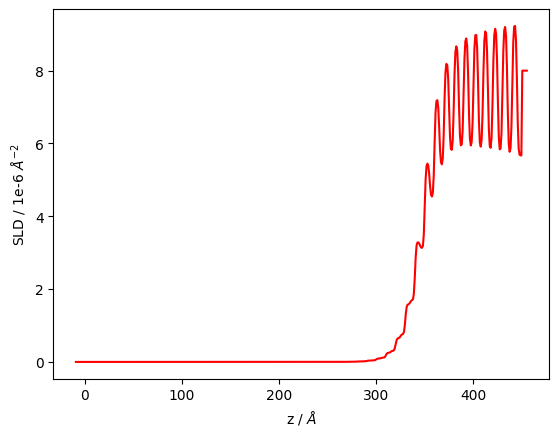

In [20]:


# a demonstration cell.
#         nlayers,
#         monolayer_thickness,
#         rel_roughness
#         sld_box1,
#         sld_diff,
#         thick_frac,
#         sig1_rel_pos,
#         sig1_width,
#         sig2_rel_pos,
#         sig2_width,
c = PTCDI(45, 10, 0.1, 5, 10, 0.5, 10, 1, 10, 0.1)
s = SLD(0) | c | SLD(8)
# print(c.slabs())
s.plot()

plt.show()

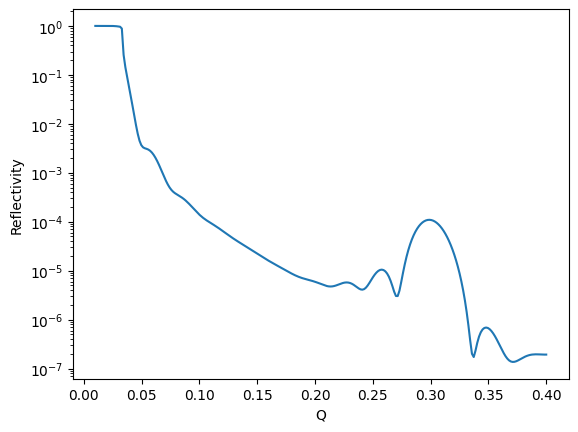

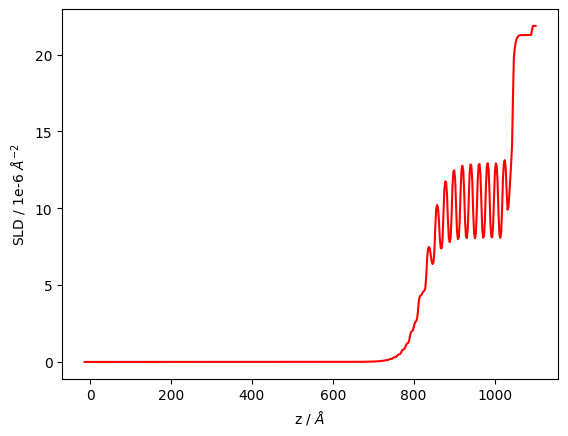

In [21]:
air = SLD(0)

si = SLD(21.861 + 0.103j, "Si")  # 19.81 + 0.093j
sio2 = SLD(21.2632 + 0.058j, "SiO2")  # 18.709

sio2_l = sio2(47, 1.2) #992 47 - pilatus fit
inter_sld = SLD(16.9,"iner_SLD")
inter_l = inter_sld(5.33, 7.6)

#         nlayers,
#         monolayer_thickness,
#         rel_roughness,
#         sld_box1,   # <----- closest to phase layer
#         sld_box2,
#         thick_frac,
#         sig1_rel_pos,
#         sig1_width,
#         sig2_rel_pos,
#         sig2_width,

# this will have p1 closest to the interface layer, then p2, etc.
# if you want it to be the other way around then you should swap p1 and p2 in the line below.
# note that funny things will happen if sig1_rel_pos and sig2_rel_pos are allowed to be greater
# than the number of monolayers
pol_slab = PTCDI(50, 20.8, 0.1, 8, 13, 0.5, 10, 1, 10, 1)

s = air | pol_slab | inter_l | sio2_l | si(0, 1)

# XRR has very good q resolution
model = ReflectModel(
    s, bkg=1e-7, dq = 1, dq_type='pointwise') 
# model.scale.setp(bounds=(0.8, 1.2), vary=True)
model.bkg.setp(bounds=(1e-10, 1e-5), vary=True)
model.dq.setp(bounds=(0, 2), vary=True)
# model.q_offset.setp(bounds=(0, 0.02), vary=True)

q2 = np.linspace(0.01, 0.4, 256)
plt.plot(q2, model(q2))
plt.xlabel("Q")
plt.ylabel("Reflectivity")
plt.yscale("log")
s.plot();

###########################
# set up varying parameters
###########################

# vary the monolayer sld's
# by setting how these Parameters change you'll be affecting
# polymer1, pol_slab.sld_box1, pol_slab.sld_box2, inter_l.sld.real, etc.
#sio2_l.thick.setp(vary=True, bounds=(1, 1000))
#sio2_l.rough.setp(vary=True, bounds=(1, 3))

inter_l.thick.setp(vary=True, bounds=(3, 20))
inter_l.rough.setp(vary=True, bounds=(1, 8))
inter_l.sld.real.setp(vary=True, bounds=(5, 21))

# vary stuff to do with multilayer
#pol_slab.nlayers.setp(vary=True, bounds=(1, 30))
pol_slab.monolayer_thickness.setp(vary=True, bounds=(19, 24))
pol_slab.sld_box1.setp(vary=True, bounds=(3, 8))
pol_slab.sld_box2.setp(vary=True, bounds=(14, 18))

pol_slab.sig1_rel_pos.setp(vary=True, bounds=(0, 30))
pol_slab.sig1_width.setp(vary=True, bounds=(0.2, 1))

pol_slab.sig2_rel_pos.setp(vary=True, bounds=(-2, 30))
pol_slab.sig2_width.setp(vary=True, bounds=(0.1, 3))
#pol_slab.rel_roughness.setp(vary=True, bounds=(0.1, 0.35))



In [22]:
objective = Objective(model, data, transform=Transform("logY"))
#objective = Objective(model, data, transform=Transform("YX4"))
#objective = Objective(model, data, transform=Transform("YX2"))
fitter = CurveFitter(objective)

In [23]:
# setup a constraint that:
# nlayers - 1 - sig1_rel_pos has to be greater than 0
# and
# nlayers - 1 - sig2_rel_pos has to be greater than 0
class DEC(object):
    def __init__(self, pars, objective):
        self.pars = pars
        self.objective = objective

    def __call__(self, x):
        self.objective.setp(x)
        nlayers = np.round(self.pars[0].value)
        sig1_rel_pos = self.pars[1].value
        sig2_rel_pos = self.pars[2].value
        
        return np.array(nlayers - 1 - sig1_rel_pos, nlayers - 1 - sig1_rel_pos)

pars = (pol_slab.nlayers, pol_slab.sig1_rel_pos, pol_slab.sig2_rel_pos)
dec = DEC(pars, objective)

from scipy.optimize import NonlinearConstraint
constraint = NonlinearConstraint(dec, 0, np.inf)

2.212351253966237: : 147it [07:02,  2.88s/it] 


________________________________________________________________________________
Structure:                
solvent: None
reverse structure: False
contract: 0

________________________________________________________________________________
Parameters:       ''       
<Parameter:  ' - thick'   , value=0 (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters:       ''       
<Parameter:   ' - sld'    , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:   ' - isld'   , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:  ' - rough'   , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:' - volfrac solvent', value=0 (fixed)  , bounds=[0.0, 1.0]>
________________________________________________________________________________
Parameters:      None      
<Parameter:      ''       , value=50 (fixed)  , bounds=[-inf, inf]>
<Parameter:      ''       , value=20.8205 +/- 0.0106, bounds=[19.0, 24.0]>
<Parameter:      ''       , val

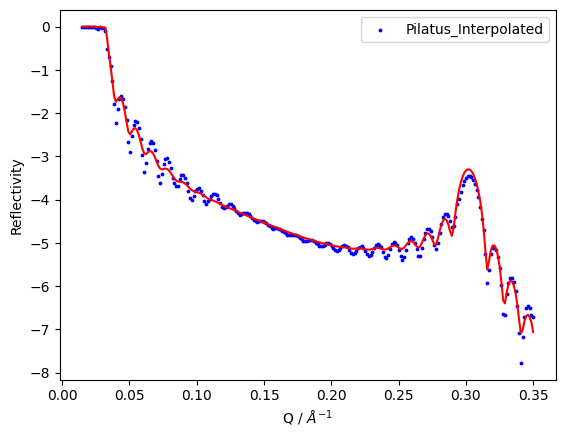

In [24]:
# only use differential_evolution, this is because nlayers has to be an integer variable
# and diffev is able to cope with that, other minimisers can't.
fitter.fit("differential_evolution")

# if you want to use the constraint
#fitter.fit("differential_evolution", constraints=(constraint,))

print(s)

objective.plot()
# plt.yscale('log')
plt.xlabel("Q / $\\AA^{-1}$")
plt.ylabel("Reflectivity")
#plt.yscale("log")
plt.legend();

0.0
0.036154804529326734


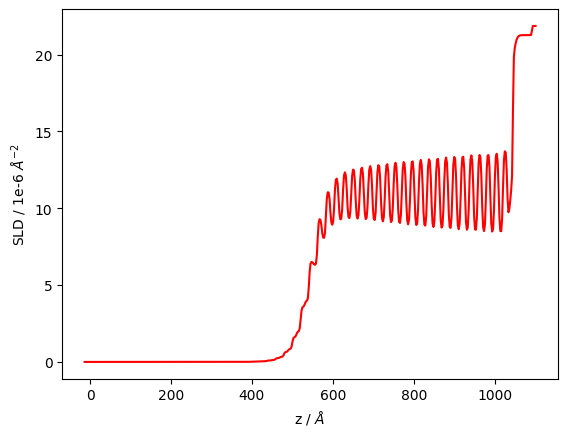

In [25]:
s.plot()
print(objective.model.q_offset.value)
print(objective.model.dq.value)

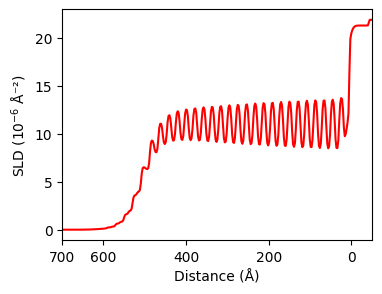

In [26]:
s1 = s

z, sld1 = s1.sld_profile()

labelsx = ['700', '600', '400', '200', '0']

fig = plt.figure(figsize=(4, 3), dpi=100) 
ax = fig.add_subplot(111)
# Plot the SLD profile
#ax.plot(z, sld1, 'r')
ax.plot(z, sld1, 'r')
ax.set_xlabel('Distance (Å)')
ax.set_ylabel('SLD ($10^{-6}$ Å⁻²)')
ax.set_xlim([500,1100])
ax.set_xticks([350, 450, 650, 850, 1050], labelsx)
plt.show()